In [1]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
from functions import *
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from pyspark.ml.feature import VectorAssembler, StringIndexer

In [2]:
spark = SparkSession.builder \
   .master("local") \
   .appName("getTestSet") \
   .config("spark.executor.memory", "8gb") \
   .getOrCreate()

sc = spark.sparkContext

In [ ]:
# pvs5 (Guidatore 2, Scenario 2) è il driving process a partire dal quale ricavo il test set completamente indipendente dal training set 
pvs5 = spark.read.option("header", True).csv('processed_data/PVS5')

In [4]:
pvs5.show(5)

+--------------+-------------------+-------------------+---------+---------------------+---------------------+---------------------+----------------------------+----------------------------+---------------------+----------------------------+----------------------------+----------------------+----------------------+----------------------+---------------------+--------------------+---------------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+--------------------+---------------------------+---------------------------+
|road_condition|      avg_longitude|       avg_latitude|avg_speed|avg_acc_x_dashboard_L|avg_acc_y_dashboard_L|avg_acc_z_dashboard_L|avg_acc_z_above_suspension_L|avg_acc_z_below_suspension_L|avg_acc_z_dashboard_R|avg_acc_z_above

In [ ]:
# creo delle colonne con longitudine e latitudine approssimate, in modo che ci sia una certa distanza tra le osservazioni selezionate per il test set, e quelle del training set
pvs5 = pvs5.withColumns({'proxy_long': F.round(F.col('avg_longitude'),3), 'proxy_lat': F.round(F.col('avg_latitude'),3)})

In [ ]:
pvs4 = spark.read.option("header", True).csv('processed_data/PVS4')
pvs4 = pvs4.withColumns({'proxy_long': F.round(F.col('avg_longitude'),3), 'proxy_lat': F.round(F.col('avg_latitude'),3)})

In [7]:
pvs6 = spark.read.option("header", True).csv('processed_data/PVS6')
pvs6 = pvs6.withColumns({'proxy_long': F.round(F.col('avg_longitude'),3), 'proxy_lat': F.round(F.col('avg_latitude'),3)})

In [ ]:
# prendo tutte le osservazioni di pvs5 che hanno le stesse coordinate di quelle in pvs4 (Scenario 1) e pvs6 (scenario 3)
test_set = pvs5.join(pvs4, ['proxy_long', 'proxy_lat'], how='leftanti').join(pvs6, ['proxy_long', 'proxy_lat'], how='leftanti')

In [9]:
pvs5.count()

133877

In [ ]:
# numero di osservazioni del test set
test_set.count()

84058

In [ ]:
# prendo un campione di tutti per visualizzare se sono rimaste delle sovrapposizioni geografiche tra le osservazioni
test_set_pd = test_set.sample(withReplacement=False, fraction=0.025, seed=8).toPandas()
pvs4_pd = pvs4.sample(withReplacement=False, fraction=0.025, seed=8).toPandas()
pvs6_pd = pvs6.sample(withReplacement=False, fraction=0.025, seed=8).toPandas()

In [12]:
test_set_pd['avg_longitude'] = test_set_pd['avg_longitude'].astype('float')
test_set_pd['avg_latitude'] = test_set_pd['avg_latitude'].astype('float')
pvs4_pd['avg_longitude'] = pvs4_pd['avg_longitude'].astype('float')
pvs4_pd['avg_latitude'] = pvs4_pd['avg_latitude'].astype('float')
pvs6_pd['avg_longitude'] = pvs6_pd['avg_longitude'].astype('float')
pvs6_pd['avg_latitude'] = pvs6_pd['avg_latitude'].astype('float')

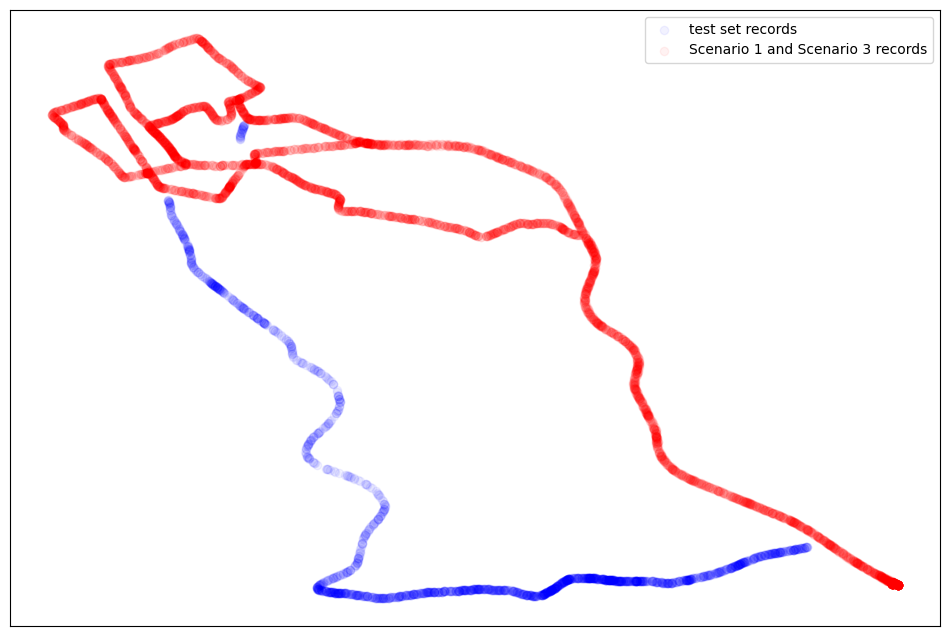

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(test_set_pd['avg_longitude'], test_set_pd['avg_latitude'], c='blue', alpha=0.05, label='test set records')
plt.scatter(pvs4_pd['avg_longitude'], pvs4_pd['avg_latitude'], c='red', alpha=0.05, label='Scenario 1 and Scenario 3 records')
plt.scatter(pvs6_pd['avg_longitude'], pvs6_pd['avg_latitude'], c='red', alpha=0.05)
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

In [ ]:
# calcolo le la composizione del test set
test_set.groupBy('road_condition').agg(F.count('*').alias('n record'), F.round(100*F.count('*')/test_set.count(), 2).alias('% record')).show()

+--------------+--------+--------+
|road_condition|n record|% record|
+--------------+--------+--------+
|           bad|   45761|   54.44|
|       regular|   15053|   17.91|
|          good|   23244|   27.65|
+--------------+--------+--------+



In [27]:
test_set = test_set.drop('proxy_long', 'proxy_lat') # tolgo proxy_lat e proxy_long che non mi servono più

In [28]:
len(test_set.columns)

32

In [ ]:
# stampo il test set
test_set.write.option("header", True).mode("overwrite").csv(f'processed_data/test_set')